# Modélisation

Ce NoteBook propose une modélisation pour les données analysées dans le NoteBook précédent (nba_players_analyse.ipynb).

Ce NoteBook est composé des parties suivantes :
- Accès aux données stockées sur Google Drive,
- Import des librairies,
- Configuration du NoteBook,
- Chargement des données,
- Séparation du jeu de données,
- Transformation des variables,
- Modèle baseline,
- Comparaison de modèles,
- Meilleur modèle,
- Problème avec API Rest.

# Accès aux données stockées sur Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import des librairies

In [3]:
# skopt: model optimization lib
!pip install -q scikit-optimize

     |████████████████████████████████| 101 kB 8.2 MB/s 


In [4]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from skopt import BayesSearchCV
from skopt.space import Real, Integer

import dill as pickle

# Configuration du NoteBook

In [5]:
CONFIG = dict (
    seed = 0,
    nbr_folds = 5,
    n_iter = 66
)

# Chargement des données

In [6]:
# Chargement des données
df = pd.read_csv("/content/drive/MyDrive/Gaetan_Travail/ML/df_a_utiliser.csv")

# Vérifions que les données se soient bien chargées
print(f"df shape: {df.shape}\n")
df.head()

df shape: (1273, 12)



,GP,PTS,FG%,3P%,FT%,OREB,DREB,AST,STL,BLK,TOV,TARGET_5Yrs
0,36,2.128232,34.7,25.0,69.9,0.530628,1.481605,1.064711,0.336472,0.336472,0.832909,0.0
1,35,2.104134,29.6,23.5,76.5,0.405465,1.098612,1.547563,0.741937,0.405465,0.955511,0.0
2,74,1.824549,42.2,24.4,67.0,0.405465,0.993252,0.693147,0.405465,0.262364,0.693147,0.0
3,58,1.902108,42.6,22.6,68.9,0.693147,0.641854,0.587787,0.470004,0.095310,0.693147,1.0
4,48,1.704748,52.4,0.0,67.4,0.693147,0.916291,0.262364,0.262364,0.336472,0.587787,1.0


# Séparation du jeu de données

Puisqu'il y a un déséquilibre des classes, nous allons utilier la fonction "train_test_split" en indiquant une stratification, afin de créer un jeu d'entraînement et un jeu de test.

Puis, avec le jeu d'entraînement, nous allons utiliser la fonction StratifiedKFold afin de créer 5 plis (choix arbitraire) qui seront utilisés afin de mettre en place une validation croisée (amélioration de la généralisation d'un modèle).

In [7]:
# Creation des jeux d'entraînement et de test

# conversion de la cible en int
df.TARGET_5Yrs = [int(x) for x in df.TARGET_5Yrs]

# séparation du jeu de données
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=CONFIG["seed"],
    stratify=df.TARGET_5Yrs
)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f"train set shape: {train_df.shape}")
print(f"test set shape:  {test_df.shape}")

train set shape: (1018, 12)
test set shape:  (255, 12)


# Transformation des variables

Nous allons mettre en place un pipeline afin d'opérer une transformation sur les données n'appartenant qu'au jeu d'entraînement (et ainsi éviter d'utiliser le jeu de validation qui correspondra au pli non utilisé dans le jeu d'entraînement).

La transformation utilisée sera "StandardScaler".

# Modèle baseline

Notre baseline sera un modèle de type "Dummy Classifier".

In [ ]:
#On cree un pipeline de traitement integrant la preparation et le modele Lasso:
baseline = Pipeline([
  ("stdScaler", StandardScaler()),
  ("dummyClf", DummyClassifier(strategy="stratified"))
])

#----------------------#

# Entraînement du modèle
cv_results = cross_validate(
    baseline,
    train_df.drop(columns=["TARGET_5Yrs"]),
    train_df.TARGET_5Yrs,
    scoring="recall",
    cv=CONFIG["nbr_folds"],
    return_estimator=True
)

#----------------------#

# prédictions
y_true = test_df.TARGET_5Yrs
start = time.time()
y_pred = cv_results["estimator"][np.argmax(cv_results["test_score"])].predict(
    test_df.drop(columns=["TARGET_5Yrs"])
)
stop = time.time()

print(f"Recall    = {recall_score(y_true, y_pred):.4f}")
print(f"F1 score  = {f1_score(y_true, y_pred):.4f}")
print(f"Precision = {precision_score(y_true, y_pred):.4f}")
print(f"Temps de prédictions = {stop - start}")

Recall    = 0.5597
F1 score  = 0.5761
Precision = 0.5933
Temps de prédictions = 0.0021622180938720703


Nous utiliserons comme score baseline :

Recall = 0.5597

# Comparaison de modèles

Pour optimiser les modèles, je vais utiliser la librairie scikit-optimize. Cette dernière permet d'effectuer des recherches bayésiennes.

Pour optimiser le score, j'utilise la métrique "F1-score".
Celle-ci étant une moyenne harmonique de la précision et du rappel, elle permet d'éviter que le modèle ne fasse des "erreurs volontaires" (classer tous les individus en 1 ou 0) pour maximiser la précision ou le rappel.

Une fois, l'entraînement fait en tentant d'optimiser le F1-score, nous allons comparer les scores des différents modèles (F1-score et Recall), ainsi que le temps mis pour prédire le jeu de test.

In [8]:
# Imbalance du jeu de données

def class_weights_function(df_target):
  # Estimate class weights based on the imbalance of the data set

  neg = df_target.value_counts()[0]
  pos = df_target.value_counts()[1]

  # weigts to correct imbalance:
  total = neg + pos

  # Scaling by total/2 helps keep the loss to a similar magnitude.
  # The sum of the weights of all examples stays the same.
  weight_for_0 = (1 / neg) * (total / 2.0)
  weight_for_1 = (1 / pos) * (total / 2.0)

  class_weights = {0: weight_for_0, 1: weight_for_1}

  return class_weights

In [9]:
# Maximisation du F1-score
def max_scores(target, y_pred, min_range=30, max_range=70, average_="binary"):

    result_threshold = []
    result_f1 = []
    result_jaccard = []
    result_prec = []
    result_recall = []

    for i in range(min_range, max_range, 1):
      threshold = i/100

      y_pred_threshold = [1 if x >= threshold else 0 for x in y_pred]
                                                           
      result_threshold.append(threshold)
      result_f1.append(f1_score(target, y_pred_threshold))        
      result_prec.append(precision_score(
          target,
          y_pred_threshold,
          average=average_)
      )
      result_recall.append(recall_score(
          target,
          y_pred_threshold,
          average=average_)
      )

    # we want to maximize the F1 score:
    index = result_f1.index(max(result_f1))
    
    print(f"Threshold = {result_threshold[index]}")
    print("\nScores:\n")
    print(f"F1 score         = {result_f1[index]:.4f}")
    print(f"Precision score  = {result_prec[index]:.4f}")
    print(f"Recall score     = {result_recall[index]:.4f}")
  
    return result_threshold[index]

In [10]:
from sklearn.metrics import fbeta_score

# Maximisation du Fbeta-score
def max_scores_fb(target, y_pred, min_range=30, max_range=70, beta_=0.5):

    result_threshold = []
    result_fb = []

    for i in range(min_range, max_range, 1):
      threshold = i/100

      y_pred_threshold = [1 if x >= threshold else 0 for x in y_pred]
                                                           
      result_threshold.append(threshold)
      result_fb.append(fbeta_score(target, y_pred_threshold, beta=beta_))

    # we want to maximize the F1 score:
    index = result_fb.index(max(result_fb))
    
    print(f"Threshold = {result_threshold[index]}")
    print("\nScores:\n")
    print(f"fbeta_score = {result_fb[index]:.4f}")
  
    return result_threshold[index]

**Régression logistique**

In [11]:
# On cree un pipeline de traitement integrant la preparation et le modele logReg:
modele_log_reg = Pipeline([
  ("stdScaler", StandardScaler()),
  ("logReg", LogisticRegression(
      penalty = "elasticnet",
      solver = "saga",
      class_weight = class_weights_function(train_df.TARGET_5Yrs),
      random_state = CONFIG["seed"]
  ))
])

# On definit les hyperparametres a faire varier:
param_grid = {
    "logReg__C": Real(1e-5, 1e+5, prior="log-uniform"),
    "logReg__l1_ratio": Real(0, 1)
}

# On cree le modele utilisant une recherche bayesienne
opt_logReg = BayesSearchCV(
    modele_log_reg,
    param_grid,
    scoring="f1",
    cv=CONFIG["nbr_folds"],
    n_jobs=-1,
    n_iter=CONFIG["n_iter"]
)

# On entraine le modele
opt_logReg.fit(
  train_df.drop(columns=["TARGET_5Yrs"]),
  train_df.TARGET_5Yrs
)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, error_score='raise',
              estimator=Pipeline(memory=None,
                                 steps=[('stdScaler',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('logReg',
                                         LogisticRegression(C=1.0,
                                                            class_weight={0: 1.3220779220779222,
                                                                          1: 0.8041074249605055},
                                                            dual=False,
                                                            fit_intercept=True,
                                                            intercept_scaling=1,
                                                            l1_ratio=None,
                          

In [12]:
# Optimisation du seuil de décision

# y_true et prédictions
y_true = train_df.TARGET_5Yrs
y_pred = opt_logReg.predict_proba(train_df.drop(columns=["TARGET_5Yrs"]))

threshold = max_scores(
    y_true,
    [x[1] for x in y_pred],
    min_range=10,
    max_range=90
)

Threshold = 0.33

Scores:

F1 score         = 0.7873
Precision score  = 0.6976
Recall score     = 0.9036


In [13]:
# Optimisation du seuil de décision

# y_true et prédictions
y_true = train_df.TARGET_5Yrs
y_pred = opt_logReg.predict_proba(train_df.drop(columns=["TARGET_5Yrs"]))

threshold = max_scores_fb(
    y_true,
    [x[1] for x in y_pred],
    min_range=10,
    max_range=90
)

Threshold = 0.51

Scores:

fbeta_score = 0.7920


In [14]:
# prédictions jeu de test
y_true = test_df.TARGET_5Yrs
start = time.time()
y_pred = opt_logReg.predict_proba(test_df.drop(columns=["TARGET_5Yrs"]))
stop = time.time()

threshold = 0.51
y_pred = [x[1] for x in y_pred]
y_pred_threshold = [1 if x >= threshold else 0 for x in y_pred]

print(f"Recall    = {recall_score(y_true, y_pred_threshold):.4f}")
print(f"F1 score  = {f1_score(y_true, y_pred_threshold):.4f}")
print(f"Precision = {precision_score(y_true, y_pred_threshold):.4f}")
print(f"Temps de prédictions = {stop - start}")

Recall    = 0.5975
F1 score  = 0.6597
Precision = 0.7364
Temps de prédictions = 0.002293825149536133


**SVM**

In [ ]:
# On cree un pipeline de traitement integrant la preparation et le modele Lasso:
modele_svc = Pipeline([
  ("stdScaler", StandardScaler()),
  ("svc", SVC(
      class_weight = class_weights_function(train_df.TARGET_5Yrs),
      random_state = CONFIG["seed"]
  ))
])

# On definit les hyperparametres a faire varier:
param_grid = {
    "svc__C": Real(1e-5, 1e+5, prior="log-uniform")
}

# On cree le modele utilisant une recherche bayesienne
opt_svc = BayesSearchCV(
    modele_svc,
    param_grid,
    scoring="f1",
    cv=CONFIG["nbr_folds"],
    n_jobs=-1,
    n_iter=CONFIG["n_iter"]
)

# On entraine le modele
opt_svc.fit(
  train_df.drop(columns=["TARGET_5Yrs"]),
  train_df.TARGET_5Yrs
)

BayesSearchCV(cv=5, error_score='raise',
              estimator=Pipeline(memory=None,
                                 steps=[('stdScaler',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('svc',
                                         SVC(C=1.0, break_ties=False,
                                             cache_size=200,
                                             class_weight={0: 1.3220779220779222,
                                                           1: 0.8041074249605055},
                                             coef0=0.0,
                                             decision_function_shape='ovr',
                                             degree=3, gamma='scale',
                                             kernel='rbf', max_iter=-1,
                             

In [ ]:
# Optimisation du seuil de décision

# y_true et prédictions
y_true = train_df.TARGET_5Yrs
y_pred = opt_svc.decision_function(train_df.drop(columns=["TARGET_5Yrs"]))

threshold = max_scores(
    y_true,
    y_pred,
    min_range=10,
    max_range=90
)

Threshold = 0.1

Scores:

F1 score         = 0.7309
Precision score  = 0.8112
Recall score     = 0.6651


In [ ]:
# prédictions jeu de test
y_true = test_df.TARGET_5Yrs
start = time.time()
y_pred = opt_svc.decision_function(test_df.drop(columns=["TARGET_5Yrs"]))
stop = time.time()

threshold = 0.1
y_pred_threshold = [1 if x >= threshold else 0 for x in y_pred]

print(f"Recall    = {recall_score(y_true, y_pred_threshold):.4f}")
print(f"F1 score  = {f1_score(y_true, y_pred_threshold):.4f}")
print(f"Precision = {precision_score(y_true, y_pred_threshold):.4f}")
print(f"Temps de prédictions = {stop - start}")

Recall    = 0.5660
F1 score  = 0.6406
Precision = 0.7377
Temps de prédictions = 0.014455080032348633


**Random Forest et Gradient Boosting**

Il y a un problème lors de l'utilisation de skopt-Bayes_search_cv et un modèle ensembliste.
Une solution a été proposée [ici](https://github.com/scikit-optimize/scikit-optimize/issues/978#issue-775632361) par l'utilisateur *AyrtonB*.

Cependant, cette modélisation est très couteuse en temps.
Je fais alors le choix de ne pas entraîner de modèles ensemblistes et passe directement à une modélisation utilisant de l'autoML.

**AutoML - AutoGluon**

Lors de l'installation d'AutGluon, je suspecte qu'il y ait une modification de certaines librairies, renant impossible l'utilisation de scikit-optimize avec les modèles de sklearn entraînés précédemment.

De ce fait, pour éviter tout problème, je préfère installer et importer AutoGluon seulement à partir d'ici dans le NoteBook.

In [ ]:
# AutoML (AutoGluon)
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0"
!pip install autogluon.tabular

!pip install catboost

In [ ]:
from autogluon.tabular import TabularPredictor

In [ ]:
# Entraînement du modèle AutoGluon

predictor = TabularPredictor(
    label="TARGET_5Yrs",
    problem_type="binary",
    eval_metric="f1",
    sample_weight="auto_weight"
).fit(
   train_df,
   time_limit=900,
   presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20210903_130843/"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20210903_130843/"
AutoGluon Version:  0.3.1
Train Data Rows:    1018
Train Data Columns: 11
Preprocessing data ...
NumExpr defaulting to 2 threads.
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12692.97 MB
	Train Data (Original)  Memory Usage: 0.09 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeat

KeyboardInterrupt: ignored

In [ ]:
# Évalutation des performances du modèle avant optimisation seuil de décision
start = time.time()
performance = predictor.evaluate(test_df)
stop = time.time()

print(f"\nTemps de prédictions = {stop - start}")

Evaluation: f1 on test data: 0.7522388059701492
Evaluations on test data:
{
    "f1": 0.7522388059701492,
    "accuracy": 0.6745098039215687,
    "balanced_accuracy": 0.635809748427673,
    "mcc": 0.2845936721958216,
    "roc_auc": 0.6864517819706499,
    "precision": 0.7159090909090909,
    "recall": 0.7924528301886793
}



Temps de prédictions = 16.251795530319214


In [ ]:
# Optimisation du seuil de décision

# y_true et prédictions
y_true = train_df.TARGET_5Yrs
y_pred = predictor.predict_proba(train_df.drop(columns=["TARGET_5Yrs"]))[1]

threshold = max_scores(
    y_true,
    y_pred,
    min_range=10,
    max_range=90
)

In [ ]:
# prédictions jeu de test
y_true = test_df.TARGET_5Yrs
y_pred = predictor.predict_proba(test_df.drop(columns=["TARGET_5Yrs"]))[1]

threshold = 0.27
y_pred_threshold = [1 if x >= threshold else 0 for x in y_pred]

print(f"Recall    = {recall_score(y_true, y_pred_threshold):.4f}")
print(f"F1 score  = {f1_score(y_true, y_pred_threshold):.4f}")
print(f"Precision = {precision_score(y_true, y_pred_threshold):.4f}")

Recall    = 0.9874
F1 score  = 0.7696
Precision = 0.6305


Comparaison des différents modèles

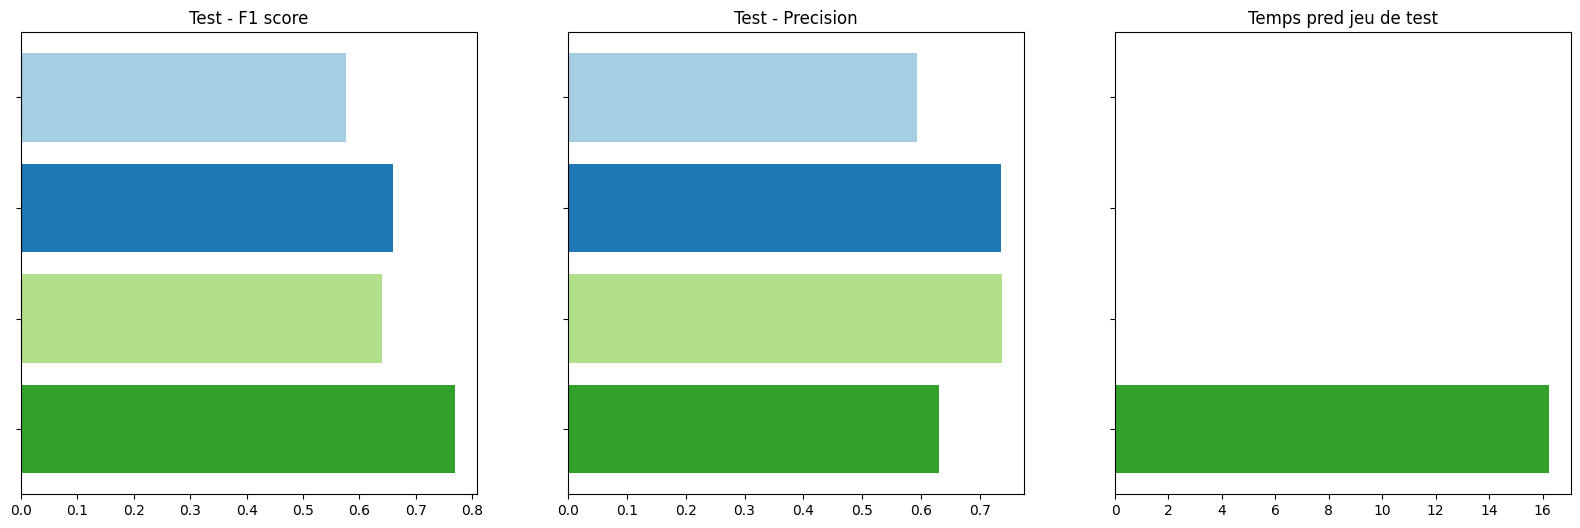

In [17]:
list_model_name = ["Baseline", "Log_reg", "SVM", "AutoML"]
list_test_f1 = [0.5761, 0.6597, 0.6406, 0.7696]
list_test_precision = [0.5933, 0.7364, 0.7377, 0.6305]
liste_temps_pred = [0.0022, 0.0023, 0.0145, 16.25]

# Visualization
plt.style.use(['default'])
f, axes = plt.subplots(1, 3, figsize=(20, 6))

# Test - F1 score
axes[0].barh(
    list_model_name,
    list_test_f1,
    color=plt.cm.Paired(np.arange(len(list_test_f1)))
)
axes[0].set_title('Test - F1 score')
axes[0].set_yticklabels([])
axes[0].invert_yaxis()

# Test - Precision
axes[1].barh(
    list_model_name,
    list_test_precision,
    color=plt.cm.Paired(np.arange(len(list_test_precision)))
)
axes[1].set_title('Test - Precision')
axes[1].set_yticklabels([])
axes[1].invert_yaxis()

# Temps pred jeu de test
axes[2].barh(
    list_model_name,
    liste_temps_pred,
    color=plt.cm.Paired(np.arange(len(liste_temps_pred)))
)
axes[2].set_title('Temps pred jeu de test')
axes[2].set_yticklabels([])
axes[2].invert_yaxis()

La régression logistique est dépassée par AutoGluon pour la valeur du F1-score.

Or, sa précision, ainsi que le temps de prédiction sont meilleurs la concernant.

C'est le modèle que je choisis par la suite.

# Meilleur modèle

Notre meilleur modèle est la régression logistique.

Nous allons à présent optimiser le seuil de décision afin de maximiser le F0.5-score.

Puis, nous afficherons la matrice de confusion produite par ce modèle, en utilisant le seuil optimal.

Enfin, nous enregistrerons notre modèle à l'aide de "dill".

Recall    = 0.6919
F0.5-score = 0.7920
Precision = 0.8218



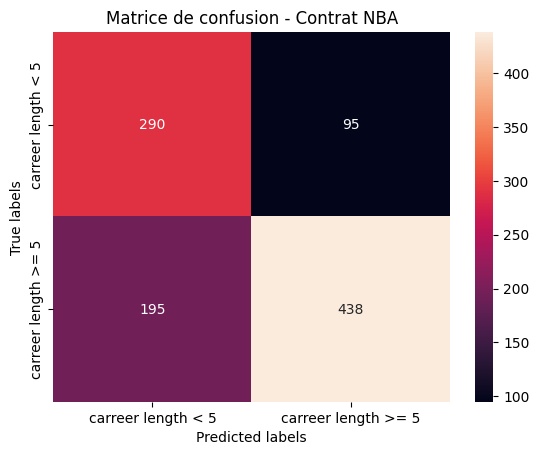

In [25]:
# Matrice de confusion
# optimisation du seuil sur le jeu d'entrainement
plt.style.use(['default'])

y_true = train_df.TARGET_5Yrs
y_pred = opt_logReg.predict_proba(train_df.drop(columns=["TARGET_5Yrs"]))

threshold = 0.51
y_pred = [x[1] for x in y_pred]
y_pred_threshold = [1 if x >= threshold else 0 for x in y_pred]

ax = sns.heatmap(
    confusion_matrix(y_true, y_pred_threshold),
    annot=True,
    fmt="d"
)

ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels");
ax.set_title("Matrice de confusion - Contrat NBA");
ax.xaxis.set_ticklabels(["carreer length < 5", "carreer length >= 5"]);
ax.yaxis.set_ticklabels(["carreer length < 5", "carreer length >= 5"]);

print(f"Recall    = {recall_score(y_true, y_pred_threshold):.4f}")
print(f"F{0.5}-score = {fbeta_score(y_true, y_pred_threshold, beta=0.5):.4f}")
print(f"Precision = {precision_score(y_true, y_pred_threshold):.4f}\n")

Recall    = 0.5975
F0.5-score = 0.7037
Precision = 0.7364



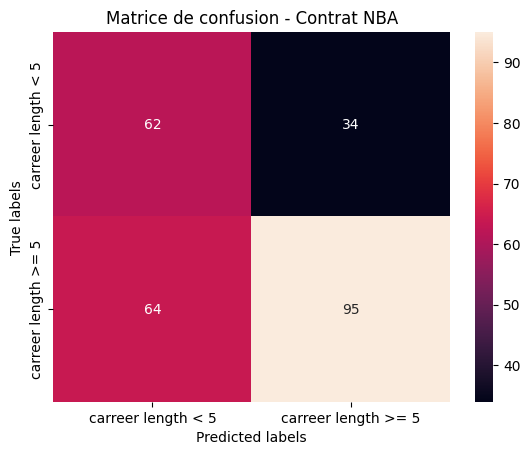

In [26]:
# Matrice de confusion
# Resulats sur le jeu de test

plt.style.use(['default'])

y_true = test_df.TARGET_5Yrs
y_pred = opt_logReg.predict_proba(test_df.drop(columns=["TARGET_5Yrs"]))

threshold = 0.51
y_pred = [x[1] for x in y_pred]
y_pred_threshold = [1 if x >= threshold else 0 for x in y_pred]

ax = sns.heatmap(
    confusion_matrix(y_true, y_pred_threshold),
    annot=True,
    fmt="d"
)

ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels");
ax.set_title("Matrice de confusion - Contrat NBA");
ax.xaxis.set_ticklabels(["carreer length < 5", "carreer length >= 5"]);
ax.yaxis.set_ticklabels(["carreer length < 5", "carreer length >= 5"]);

print(f"Recall    = {recall_score(y_true, y_pred_threshold):.4f}")
print(f"F{0.5}-score = {fbeta_score(y_true, y_pred_threshold, beta=0.5):.4f}")
print(f"Precision = {precision_score(y_true, y_pred_threshold):.4f}\n")

In [ ]:
# Enregistrement du modèle
path = "/content/drive/MyDrive/Gaetan_Travail/ML/"

with open(path + "model_logReg.pk", "wb") as file:
	pickle.dump(opt_logReg, file)